# 성능 최적화 종합실습 : Car seat sales
유아용 카시트 매출액을 예측해 봅시다.

* 카시트에 대해서 지역 매장 별 매출액을 예측하고자 합니다.

![](https://cdn.images.express.co.uk/img/dynamic/24/590x/child-car-seat-986556.jpg?r=1532946857754)

## 1.환경준비

### (1) Import

In [1]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import * 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings(action='ignore')

### (2) 함수 생성

* 선형회귀용 전진선택법

In [2]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def forward_stepwise_linear(x_train, y_train):

    # 변수목록, 선택된 변수 목록, 단계별 모델과 AIC 저장소 정의
    features = list(x_train)
    selected = []
    step_df = pd.DataFrame({ 'step':[], 'feature':[],'aic':[]})

    # 
    for s in range(0, len(features)) :
        result =  { 'step':[], 'feature':[],'aic':[]}

        # 변수 목록에서 변수 한개씩 뽑아서 모델에 추가
        for f in features :
            vars = selected + [f]
            x_tr = x_train[vars]
            model = OLS(y_train, add_constant(x_tr)).fit(disp=False)
            result['step'].append(s+1)
            result['feature'].append(vars)
            result['aic'].append(model.aic)
        
        # 모델별 aic 집계
        temp = pd.DataFrame(result).sort_values('aic').reset_index(drop = True)

        # 만약 이전 aic보다 새로운 aic 가 크다면 멈추기
        if step_df['aic'].min() < temp['aic'].min() :
            break
        step_df = pd.concat([step_df, temp], axis = 0).reset_index(drop = True)

        # 선택된 변수 제거
        v = temp.loc[0,'feature'][s]
        features.remove(v)

        selected.append(v)
    
    # 선택된 변수와 step_df 결과 반환
    return selected, step_df

In [3]:
# model = OLS(y_train, add_constant(x_tr)).fit(disp=False) 하면 안나온다.

* 변수 중요도 그래프

In [4]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

### (3) Data Loading

In [5]:
data_path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
data = pd.read_csv(data_path)

**변수설명**
> * Sales - 각 지역 판매량(단위 : 1000개) <== Target
* CompPrice - 각 지역 경쟁사 가격
* Income - 각 지역 평균 소득수준(단위 : 1000달러)
* Advertising - 각 지역, 회사의 광고 예산(단위 : 1000달러)
* Population - 지역 인구수(단위 : 1000명)
* Price - 자사 지역별 판매가격
* ShelveLoc - 진열상태
* Age - 지역 인구의 평균 연령
* Education - 각 지역 교육수준 레벨
* Urban - 매장 도시 지역 여부
* US - 매장이 미국에 있는지 여부

## 2.데이터 이해

* 둘러보기

In [6]:
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## 3.데이터 준비

### (1) 데이터 정리

In [7]:
data['Diff_Price'] = data['CompPrice'] - data['Price']
data.drop('CompPrice', axis = 1, inplace = True)

### (2) 데이터분할1 : x, y 나누기

In [8]:
target = 'Sales'
x = data.drop(target,axis=1)
y = data.loc[:,target]

In [9]:
x

,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,Diff_Price
0,73,11,276,120,Bad,42,17,Yes,Yes,18
1,48,16,260,83,Good,65,10,Yes,Yes,28
2,35,10,269,80,Medium,59,12,Yes,Yes,33
3,100,4,466,97,Medium,55,14,Yes,Yes,20
4,64,3,340,128,Bad,38,13,Yes,No,13
...,...,...,...,...,...,...,...,...,...,...
395,108,17,203,128,Good,33,14,Yes,Yes,10
396,23,3,37,120,Medium,55,11,No,Yes,19
397,26,12,368,159,Medium,40,18,Yes,Yes,3
398,79,7,284,95,Bad,50,12,Yes,Yes,5


In [10]:
y

0       9.50
1      11.22
2      10.06
3       7.40
4       4.15
       ...  
395    12.57
396     6.14
397     7.41
398     5.94
399     9.71
Name: Sales, Length: 400, dtype: float64

### (3) NA 조치

In [11]:
data.isna().sum()

Sales          0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
Diff_Price     0
dtype: int64

### (4) 가변수화

In [12]:
dump_col = ['ShelveLoc','Urban','US']
x = pd.get_dummies(x,columns=dump_col,drop_first=True)
x.head()

,Income,Advertising,Population,Price,Age,Education,Diff_Price,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,73,11,276,120,42,17,18,0,0,1,1
1,48,16,260,83,65,10,28,1,0,1,1
2,35,10,269,80,59,12,33,0,1,1,1
3,100,4,466,97,55,14,20,0,1,1,1
4,64,3,340,128,38,13,13,0,0,1,0


### (5) 데이터분할2 : train : validation 나누기

In [13]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=.3)

### (6) Scaling
KNN 알고리즘을 적용하기 위해서는 스케일링을 해야 합니다.

In [14]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

## 4.모델링



### (1) 선형회귀

In [21]:
vars,result = forward_stepwise_linear(x_train,y_train)

In [22]:
vars

['Diff_Price',
 'ShelveLoc_Good',
 'Advertising',
 'Age',
 'ShelveLoc_Medium',
 'Income',
 'US_Yes',
 'Education']

In [25]:
lr_m1 = LinearRegression()
lr_m1.fit(x_train[vars], y_train)
p1 = lr_m1.predict(x_val[vars])

print('RMSE : ', mean_squared_error(y_val, p1, squared=False))
print('MAE  : ', mean_absolute_error(y_val, p1))
print('MAPE : ', mean_absolute_percentage_error(y_val, p1))

RMSE :  1.0030960970005893
MAE  :  0.7846950800197199
MAPE :  0.1716383368625286


In [26]:
lr_m2 = LinearRegression()
lr_m2.fit(x_train,y_train)
p2 = lr_m2.predict(x_val)

print('RMSE :', mean_squared_error(y_val,p2,squared=False))
print('MAE :', mean_absolute_error(y_val,p2))
print('MAPE: ',mean_absolute_percentage_error(y_val,p2))

RMSE : 1.0004293996864204
MAE : 0.7836815488531722
MAPE:  0.16913671705705122



### (2) KNN

In [27]:
grid_param2 = {'n_neighbors' : range(1,100,2), 'metric':['euclidean','manhattan']}

In [28]:
model2 = KNeighborsRegressor()

In [29]:
model2_gs = GridSearchCV(model2,grid_param2,cv=5)
model2_gs.fit(x_train_s,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 100, 2)})

In [31]:
model2_gs.best_params_

{'metric': 'manhattan', 'n_neighbors': 5}

In [32]:
model2_gs.best_score_

0.4892278190917626

In [34]:
p2 = model2_gs.predict(x_val_s)

In [35]:
print('RMSE :',mean_squared_error(y_val,p2,squared=False))
print('MAE :',mean_absolute_error(y_val,p2))
print('MAPE :',mean_absolute_percentage_error(y_val,p2))

RMSE : 1.7404710473508793
MAE : 1.4072333333333333
MAPE : 0.48375944605171994


In [58]:
result2 = pd.DataFrame(model2_gs.cv_results_)
temp2 = result2.loc[:,['param_n_neighbors','param_metric','mean_test_score']]
temp2.head()

,param_n_neighbors,param_metric,mean_test_score
0,1,euclidean,0.254874
1,3,euclidean,0.468392
2,5,euclidean,0.472795
3,7,euclidean,0.476757
4,9,euclidean,0.487837


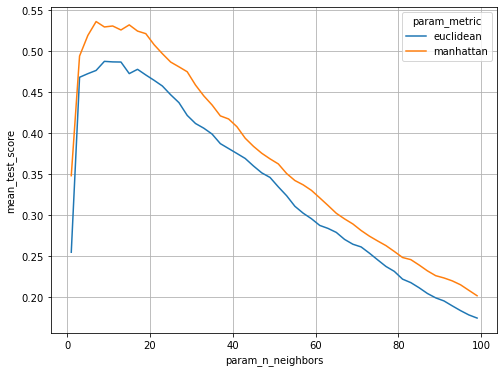

In [60]:
plt.figure(figsize=(8,6))
sns.lineplot(x='param_n_neighbors',y='mean_test_score',data=temp2,hue='param_metric')
plt.grid()
plt.show()

### (3) Decision Tree

In [42]:
params = {'max_depth': range(2,11)}
params

{'max_depth': range(2, 11)}

In [53]:
m = DecisionTreeRegressor()
dt_m = GridSearchCV(m,params,cv=5)

In [54]:
dt_m.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(2, 11)})

In [55]:
dt_m.best_params_

{'max_depth': 5}

In [56]:
dt_m.best_score_

0.5312733896569511

In [57]:
p3 = dt_m.predict(x_val)
print('RMSE :',mean_squared_error(y_val,p3,squared=False))
print('MAE :',mean_absolute_error(y_val,p3))
print('MAPE :',mean_absolute_percentage_error(y_val,p3))

RMSE : 1.4389304059205263
MAE : 1.1352521723646722
MAPE : 0.3723915262702188


In [58]:
result = pd.DataFrame(dt_m.cv_results_)

In [59]:
temp = result.loc[:,['param_max_depth','mean_test_score']]
temp.head()

,param_max_depth,mean_test_score
0,2,0.432993
1,3,0.496422
2,4,0.504971
3,5,0.531273
4,6,0.474420


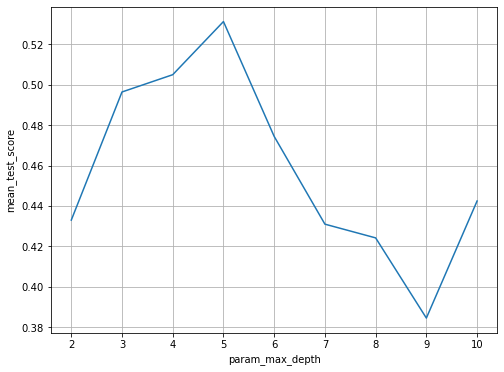

In [60]:
plt.figure(figsize=(8,6))
sns.lineplot(x='param_max_depth',y='mean_test_score',data=temp)
plt.grid()
plt.show(*)

### (4) Random Forest

In [61]:
# dictionary형태로 선언
params = {'max_depth' : range(2,21)}
params

{'max_depth': range(2, 21)}

In [62]:
m = RandomForestRegressor()

rf_m = GridSearchCV(m,params,cv=5)

In [63]:
rf_m.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(2, 21)})

In [64]:
rf_m.best_params_

{'max_depth': 8}

In [65]:
rf_m.best_score_

0.7339977885959973

In [66]:
p4 = rf_m.predict(x_val)
print('RMSE :',mean_squared_error(y_val,p4,squared=False))
print('MAE :',mean_absolute_error(y_val,p4))
print('MAPE :',mean_absolute_percentage_error(y_val,p4))

RMSE : 1.224326290121998
MAE : 0.9457850167544791
MAPE : 0.3046290685904774


In [67]:
result = pd.DataFrame(rf_m.cv_results_)

In [68]:
temp = result.loc[:, ['param_max_depth','mean_test_score']]
temp.head()

,param_max_depth,mean_test_score
0,2,0.500000
1,3,0.583024
2,4,0.661677
3,5,0.701041
4,6,0.720176


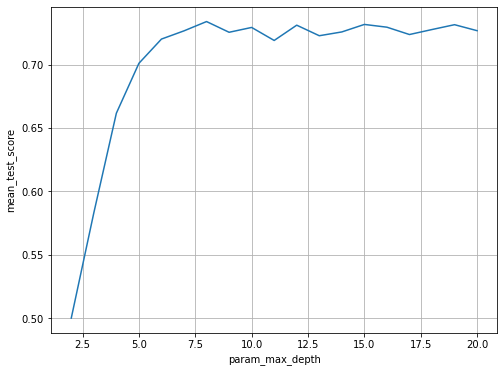

In [69]:
plt.figure(figsize=(8,6))
sns.lineplot(x='param_max_depth',y='mean_test_score',data=temp)
plt.grid()
plt.show()

### (5) XGB

In [71]:
model5 = XGBRegressor(objective='reg:squarederror')

In [72]:
model5.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [73]:
pred5 = model5.predict(x_val)

In [74]:
len(y_val)

120

In [75]:
len(pred5)

120

In [77]:
grid_param5 = {'n_estimators':[20,30,50,100],'learning_rate':np.linspace(0.001,0.1,30)}
model5 = XGBRegressor(objective='reg:squarederror')
model5_gs = GridSearchCV(model5,grid_param5,cv=5)
model5_gs.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
             param_grid={'learning_rate': array([0.001     , 0.00441379, 0.00782759, 0.01124138, 0.01465517,
       0.01806897, 0.02148276, 0.02489655, 0.02831034, 0.03172414,
       0.03513793, 0.03855172, 0.04196552, 0.04537931, 0.0487931 ,
       0.0522

In [78]:
model5_gs.best_params_

{'learning_rate': 0.05220689655172414, 'n_estimators': 100}

In [79]:
model5_gs.best_score_

0.7551624006294396

In [80]:
p5 = model5_gs.predict(x_val)
print('RMSE :',mean_squared_error(y_val,p5,squared=False))
print('MAE :',mean_absolute_error(y_val,p5))
print('MAPE :',mean_absolute_percentage_error(y_val,p5))

RMSE : 1.3636677629450717
MAE : 1.0689080297152203
MAPE : 0.274487983697974


In [81]:
result5 = pd.DataFrame(model5_gs.cv_results_)

In [82]:
temp5 = result5.loc[:, ['param_n_estimators', 'param_learning_rate','mean_test_score']]
temp5.head()

,param_n_estimators,param_learning_rate,mean_test_score
0,20,0.001,-6.071217
1,30,0.001,-5.948107
2,50,0.001,-5.707918
3,100,0.001,-5.136613
4,20,0.004414,-5.264158


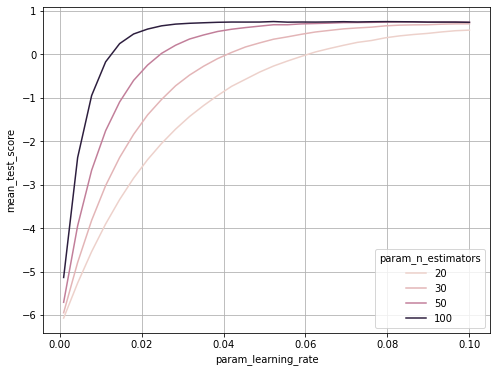

In [83]:
plt.figure(figsize=(8,6))
sns.lineplot(x='param_learning_rate',y='mean_test_score',data=temp5,hue='param_n_estimators')
plt.grid()
plt.show()

In [ ]:
# 14 복습시 강사님 코드 참고

### (6) SVM

In [84]:
params = {'C':np.linspace(0.01,100,50),'gamma':[0.001,0.01,.1,1]}
params

{'C': array([1.00000000e-02, 2.05061224e+00, 4.09122449e+00, 6.13183673e+00,
        8.17244898e+00, 1.02130612e+01, 1.22536735e+01, 1.42942857e+01,
        1.63348980e+01, 1.83755102e+01, 2.04161224e+01, 2.24567347e+01,
        2.44973469e+01, 2.65379592e+01, 2.85785714e+01, 3.06191837e+01,
        3.26597959e+01, 3.47004082e+01, 3.67410204e+01, 3.87816327e+01,
        4.08222449e+01, 4.28628571e+01, 4.49034694e+01, 4.69440816e+01,
        4.89846939e+01, 5.10253061e+01, 5.30659184e+01, 5.51065306e+01,
        5.71471429e+01, 5.91877551e+01, 6.12283673e+01, 6.32689796e+01,
        6.53095918e+01, 6.73502041e+01, 6.93908163e+01, 7.14314286e+01,
        7.34720408e+01, 7.55126531e+01, 7.75532653e+01, 7.95938776e+01,
        8.16344898e+01, 8.36751020e+01, 8.57157143e+01, 8.77563265e+01,
        8.97969388e+01, 9.18375510e+01, 9.38781633e+01, 9.59187755e+01,
        9.79593878e+01, 1.00000000e+02]),
 'gamma': [0.001, 0.01, 0.1, 1]}

In [85]:
m= SVR()
svm_m = GridSearchCV(m,params,cv=5)

In [86]:
svm_m.fit(x_train_s,y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([1.00000000e-02, 2.05061224e+00, 4.09122449e+00, 6.13183673e+00,
       8.17244898e+00, 1.02130612e+01, 1.22536735e+01, 1.42942857e+01,
       1.63348980e+01, 1.83755102e+01, 2.04161224e+01, 2.24567347e+01,
       2.44973469e+01, 2.65379592e+01, 2.85785714e+01, 3.06191837e+01,
       3.26597959e+01, 3.47004082e+01, 3.67410204e+01, 3.878163...
       5.71471429e+01, 5.91877551e+01, 6.12283673e+01, 6.32689796e+01,
       6.53095918e+01, 6.73502041e+01, 6.93908163e+01, 7.14314286e+01,
       7.34720408e+01, 7.55126531e+01, 7.75532653e+01, 7.95938776e+01,
       8.16344898e+01, 8.36751020e+01, 8.57157143e+01, 8.77563265e+01,
       8.97969388e+01, 9.18375510e+01, 9.38781633e+01, 9.59187755e+01,
       9.79593878e+01, 1.00000000e+02]),
                         'gamma': [0.001, 0.01, 0.1, 1]})

In [87]:
svm_m.best_params_

{'C': 100.0, 'gamma': 0.01}

In [88]:
svm_m.best_score_

0.8453906620198023

In [89]:
p7 = svm_m.predict(x_val_s)
print('RMSE : ', mean_squared_error(y_val, p7, squared=False))
print('MAE  : ', mean_absolute_error(y_val, p7))
print('MAPE : ', mean_absolute_percentage_error(y_val, p7))

RMSE :  1.026157110288414
MAE  :  0.7857020748715499
MAPE :  0.20316741176284908


In [90]:
result = pd.DataFrame(svm_m.cv_results_)

In [91]:
temp = result.loc[:, ['param_C','param_gamma','mean_test_score']]
temp['param_gamma'] = temp['param_gamma'].astype('str')
temp.head()

,param_C,param_gamma,mean_test_score
0,0.01,0.001,-0.028224
1,0.01,0.01,-0.026490
2,0.01,0.1,-0.014345
3,0.01,1,-0.008329
4,2.050612,0.001,0.006099


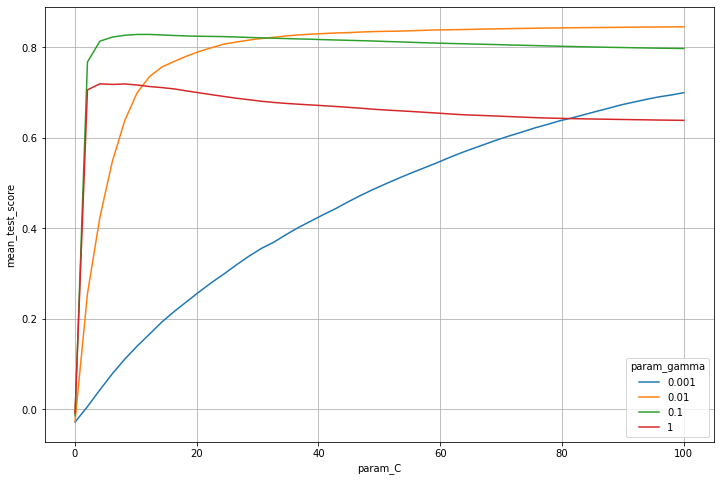

In [92]:
plt.figure(figsize = (12,8))
sns.lineplot(x = 'param_C', y = 'mean_test_score', data = temp, hue = 'param_gamma')
plt.grid()
plt.show()